<h1><center><font color=D00000>Q-learning в средах OpenAI.gym</font></center></h1>

### <font color=black>Евгений Пономарев</font>
#### <font color=green>Сколковский институт науки и технологий</font>

Библиотеки:
* `pip install gym[atari]`
* `pip install keras`
* `pip install pandas`
* `pip install matplotlib`

[Документация к openai.gym](https://gym.openai.com/docs/)

Р. С. Саттон, Э. Г. Барто "Обучение с подкреплением"

<h2><center><font color=D00000>Обучение с подкреплением aka Reinforcement learning:</font></center></h2>
 
В классической постановке предполагается **Марковский процесс принятия решений (Markov Decision Process)**:

Состоит из:
* Среды
* Агента
    
<img src="http://pp.userapi.com/c621707/v621707705/23555/2WlxiB6Di3o.jpg" alt="MDP" style="width: 600px;"/>

**MDP** задается через: 
* Множество состояний среды $\mathrm{S} : s_t \in \mathrm{S}$
* Доступные действия $\mathrm{A}: a_t \in \mathrm{A}$
* Модель среды (обычно неизвестна агенту): $s_{t+1} \sim \mathrm{P}_{env}(s_{t+1} | s_t, a_t)$
* Функция награды (обычно неизвестна агенту): $r_{t} \sim \mathrm{R}(r_{t} | a_t, s_t)$
  
Агент совершает действия в соответствии с выработанной политикой:
* $a_t \sim \pi(a_t|s_t)$

<font color=green>Цель агента - максимизировать ожидание кумулятивной награды:
$$R(\pi) = \mathbb{E}_{\pi, P, R} \sum_{t=start}^{end}{r_t} \to \max_{\pi}$$
    </font></center>


Основной плюс - можно не размечать данные

# Табличный Q-learning

Сопоставим каждой паре $(s,a)$ (состояние, действие) значение функции ценности действия - **$Q(s,a)$**
$$Q(s_t, a_t) = \mathbb{E}_{\pi, P, R} \sum_{i=0}^{N}{\gamma^ir_{t+i}}$$

В простейшем случае, когда s~1,10,100; a~1,10 можно просто выучить, что нужно делать, т.е. задать таблицу: 

| Q(s,a)| $s_1$ | $s_2$  | $s_3$ | ... |
|-----|-----|------|-----|-----|
| $a_1$ | 5   | 0    | -4  | ... |
| $a_2$ | -7   | 4    | 3   | ... |
| $a_3$ | 0   | -1 | -11  | ... |



Тогда награда за игру (эпизод): $$R(\pi) = \sum_{t=start}^{end}{r_t} \sim \sum_{t=start}^{end} Q(s_t|a_t)$$


Искомая $Q$ функция:
$$Q^*(s,a) = max_{\pi}Q^{\pi}(s,a)$$

Тогда жадная политика решает исходную задачу

$$ a_t = \arg\max_a Q(s,a) $$

Уравнение Беллмана для оптимальной функции:

$$Q^*(s,a) = \mathbb{E}_{P_{env}}(r_{t+1} + \gamma \max_{a'\in A} Q^*(s_{t+1},a')~~|~~s_t = s, a_t = a)$$




$$Q(s_{t}, a_t) = r_t + \gamma \cdot \max_{a' \in A}Q(s_{t+1}|a')$$





Оценка $Q(s, a)$ экспоненциальным скользящим средним:


$$ Q(s, a) := Q(s, a) + \alpha \cdot [(r(a,s) + \gamma \cdot \max_{a'\ \in A} Q(s',a')) - Q(s,a)] $$

$$ Q(s,a) \to r(a,s) + \gamma \cdot \max Q(s')$$

<h2><center><font color=#D00000>CartPole</font></center></h2>
<img src="cartpole_gif.gif" alt="MDP" style="width: 600px;"/>
### Вектор наблюдения

Num | Observation | Min | Max
---|---|---|---
0 | Позиция тележки | -2.4 | 2.4
1 | Скорость тележки | -Inf | Inf
2 | Угол наклона палки | ~ -41.8&deg; | ~ 41.8&deg;
3 | Угловая скорость палки | -Inf | Inf

### Действия

Num | Action
--- | ---
0 | Толкнуть влево
1 | Толкнуть вправо


### Награда
1 за каждый шаг

### Начальное состояние
Случайные числа ±0.05

### Завершение эпизода
1. Наклон палки = ±20.9°
2. Положение тележки = ±2.4 (центр тележки за пределами экрана)
3. Длительность эпизода 200 (v.0) или 500 (v.1)

### Условия победы
Продержаться 100 последовательных эпизодов со средним результатом более 195 (v.0) или 475 (v.1)

In [15]:
import gym
import numpy as np
import random
import pandas
import matplotlib.pyplot as plt
random.seed(853)

In [16]:
class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma):
        self.q = {}
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha      # discount constant
        self.gamma = gamma      # discount factor
        self.actions = actions

    def chooseAction(self, state, return_q=False):
        q = [self.q.get((state, a), 0.) for a in self.actions]
        maxQ = max(q)
        
        # Отвечает за баланс исследование-использование (exploration vs expluatation)
        # С вероятностью epsilon случайное действие, 1-epsilon - argmax(Q)
        if random.random() < self.epsilon:
            return random.choice(self.actions)

        count = q.count(maxQ)
        # Если максимум Q достигается для двух и более действий - берем любое
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)
        
        action = self.actions[i]
        if return_q: # if they want it, give it!
            return action, q
        return action
    
    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.q.get((state, action), 0) for a in self.actions])
        new_q = reward + self.gamma*maxqnew

        old_q = self.q.get((state, action), None)
        if old_q is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = old_q + self.alpha * (new_q - old_q)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [17]:
env = gym.make('CartPole-v0')
goal_average_steps = 195
max_number_of_steps = 200
# Для создания видео и отправки данных на сайт gym.openai.com
env = gym.wrappers.Monitor(env, '/tmp/cartpole-experiment-1', force=True)

n_bins = 8
n_bins_angle = 10

# Дискретизуем непрерывное пространство состояний в n_bins^2*n_bins_angle^2
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

# Инициализация табличного Q-learning
alpha = 0.3
gamma = 0.95
epsilon = 0.
qlearn = QLearn(actions=range(env.action_space.n),
                alpha=alpha, gamma=gamma, epsilon=epsilon)

[2017-10-06 15:38:05,815] Making new env: CartPole-v0
[2017-10-06 15:38:05,823] Clearing 26 monitor files from previous run (because force=True was provided)


```C
init s
init Q
eps = 0.1
alpha = 0.5
    
for episode = 1,M do:
    с вероятностью eps:
        a = ramdom(A)
    else:
        a = argmax(Q[s,a])
    
    Совершить действие a;
    Получить награду r;
    Получить новое состояние s_new;
    
    Улучшить стратегию:
        Q[s,a] := Q[s,a] + alpha*((r + max(Q[s_new,:])) - Q[s,a])
    
    s := s_new
```

In [18]:

last_reward = np.ndarray(0)
for i_episode in range(3000):
    
    # получим наблюдение
    observation = env.reset()
    # дискретизуем и создадим состояние
    cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
    state = build_state([to_bin(cart_position, cart_position_bins),
                     to_bin(pole_angle, pole_angle_bins),
                     to_bin(cart_velocity, cart_velocity_bins),
                     to_bin(angle_rate_of_change, angle_rate_bins)])
    cum_reward = 0
    for t in range(max_number_of_steps):
        # можно смотреть, как агент учится
#         if i_episode % 300 == 0: 
#             env.render()
        
        # в соответствии с политикой выберем действие
        action = qlearn.chooseAction(state)
        # получим новое наблюдение, награду, метку конца эпизода
        observation, reward, is_done, _ = env.step(action)
        cum_reward += reward
        # дискретизуем и создадим состояние
        cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
        new_state = build_state([to_bin(cart_position, cart_position_bins),
                         to_bin(pole_angle, pole_angle_bins),
                         to_bin(cart_velocity, cart_velocity_bins),
                         to_bin(angle_rate_of_change, angle_rate_bins)])


        if not(is_done):
            qlearn.learn(state, action, reward, new_state)
            state = new_state
        else:
            # штраф за проигрыш
            reward = -200
            qlearn.learn(state, action, reward, new_state)
            last_reward = np.append(last_reward, cum_reward)
            break
    print("episode: {}, score: {}, 30-mean: {:0.1f}".format(i_episode, t, last_reward[-30:].mean()))
    if (last_reward[-100:].mean() > goal_average_steps):
        print ("Win!")
        break
env.close()
# gym.upload('/tmp/cartpole-experiment-1', algorithm_id='simple Q-learning', api_key='your-key')

[2017-10-06 15:38:08,430] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000000.mp4
[2017-10-06 15:38:08,742] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000001.mp4


episode: 0, score: 12, 30-mean: 13.0


[2017-10-06 15:38:09,069] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000008.mp4


episode: 1, score: 14, 30-mean: 14.0
episode: 2, score: 18, 30-mean: 15.7
episode: 3, score: 8, 30-mean: 14.0
episode: 4, score: 13, 30-mean: 14.0
episode: 5, score: 9, 30-mean: 13.3
episode: 6, score: 20, 30-mean: 14.4
episode: 7, score: 15, 30-mean: 14.6


[2017-10-06 15:38:10,689] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000027.mp4


episode: 8, score: 90, 30-mean: 23.1
episode: 9, score: 14, 30-mean: 22.3
episode: 10, score: 13, 30-mean: 21.5
episode: 11, score: 12, 30-mean: 20.8
episode: 12, score: 11, 30-mean: 20.2
episode: 13, score: 16, 30-mean: 19.9
episode: 14, score: 11, 30-mean: 19.4
episode: 15, score: 10, 30-mean: 18.9
episode: 16, score: 8, 30-mean: 18.3
episode: 17, score: 13, 30-mean: 18.1
episode: 18, score: 95, 30-mean: 22.2
episode: 19, score: 8, 30-mean: 21.5
episode: 20, score: 21, 30-mean: 21.5
episode: 21, score: 42, 30-mean: 22.5
episode: 22, score: 23, 30-mean: 22.6
episode: 23, score: 32, 30-mean: 23.0
episode: 24, score: 77, 30-mean: 25.2
episode: 25, score: 9, 30-mean: 24.6
episode: 26, score: 124, 30-mean: 28.3


[2017-10-06 15:38:11,255] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000064.mp4


episode: 27, score: 22, 30-mean: 28.1
episode: 28, score: 75, 30-mean: 29.8
episode: 29, score: 73, 30-mean: 31.3
episode: 30, score: 82, 30-mean: 33.6
episode: 31, score: 63, 30-mean: 35.2
episode: 32, score: 16, 30-mean: 35.2
episode: 33, score: 63, 30-mean: 37.0
episode: 34, score: 90, 30-mean: 39.6
episode: 35, score: 87, 30-mean: 42.2
episode: 36, score: 88, 30-mean: 44.4
episode: 37, score: 10, 30-mean: 44.3
episode: 38, score: 10, 30-mean: 41.6
episode: 39, score: 20, 30-mean: 41.8
episode: 40, score: 100, 30-mean: 44.7
episode: 41, score: 67, 30-mean: 46.5
episode: 42, score: 10, 30-mean: 46.5
episode: 43, score: 10, 30-mean: 46.3
episode: 44, score: 61, 30-mean: 48.0
episode: 45, score: 26, 30-mean: 48.5
episode: 46, score: 140, 30-mean: 52.9
episode: 47, score: 16, 30-mean: 53.0
episode: 48, score: 103, 30-mean: 53.3
episode: 49, score: 78, 30-mean: 55.6
episode: 50, score: 18, 30-mean: 55.5
episode: 51, score: 9, 30-mean: 54.4
episode: 52, score: 9, 30-mean: 53.9
episode: 53

[2017-10-06 15:38:12,452] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000125.mp4



episode: 95, score: 66, 30-mean: 48.6
episode: 96, score: 34, 30-mean: 49.4
episode: 97, score: 101, 30-mean: 50.2
episode: 98, score: 15, 30-mean: 49.6
episode: 99, score: 105, 30-mean: 50.9
episode: 100, score: 41, 30-mean: 48.7
episode: 101, score: 19, 30-mean: 44.8
episode: 102, score: 59, 30-mean: 42.3
episode: 103, score: 102, 30-mean: 45.3
episode: 104, score: 123, 30-mean: 47.2
episode: 105, score: 79, 30-mean: 46.1
episode: 106, score: 53, 30-mean: 47.4
episode: 107, score: 52, 30-mean: 48.8
episode: 108, score: 59, 30-mean: 49.6
episode: 109, score: 96, 30-mean: 52.5
episode: 110, score: 47, 30-mean: 53.7
episode: 111, score: 58, 30-mean: 54.0
episode: 112, score: 121, 30-mean: 55.0
episode: 113, score: 100, 30-mean: 58.1
episode: 114, score: 97, 30-mean: 59.6
episode: 115, score: 193, 30-mean: 62.2
episode: 116, score: 66, 30-mean: 63.9
episode: 117, score: 169, 30-mean: 69.1
episode: 118, score: 120, 30-mean: 72.6
episode: 119, score: 142, 30-mean: 76.5
episode: 120, score

[2017-10-06 15:38:14,701] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000216.mp4



episode: 211, score: 114, 30-mean: 127.9
episode: 212, score: 134, 30-mean: 130.7
episode: 213, score: 92, 30-mean: 130.2
episode: 214, score: 192, 30-mean: 132.6
episode: 215, score: 111, 30-mean: 134.2
episode: 216, score: 125, 30-mean: 131.8
episode: 217, score: 142, 30-mean: 132.5
episode: 218, score: 96, 30-mean: 131.8
episode: 219, score: 130, 30-mean: 129.5
episode: 220, score: 110, 30-mean: 128.6
episode: 221, score: 125, 30-mean: 130.9
episode: 222, score: 102, 30-mean: 128.5
episode: 223, score: 48, 30-mean: 124.4
episode: 224, score: 63, 30-mean: 121.6
episode: 225, score: 96, 30-mean: 118.9
episode: 226, score: 27, 30-mean: 113.6
episode: 227, score: 54, 30-mean: 113.0
episode: 228, score: 40, 30-mean: 111.8
episode: 229, score: 170, 30-mean: 110.8
episode: 230, score: 163, 30-mean: 113.6
episode: 231, score: 120, 30-mean: 116.1
episode: 232, score: 108, 30-mean: 113.7
episode: 233, score: 46, 30-mean: 108.6
episode: 234, score: 98, 30-mean: 109.2
episode: 235, score: 106,

[2017-10-06 15:38:17,643] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000343.mp4



episode: 325, score: 48, 30-mean: 128.5
episode: 326, score: 153, 30-mean: 127.0
episode: 327, score: 172, 30-mean: 126.2
episode: 328, score: 91, 30-mean: 123.7
episode: 329, score: 92, 30-mean: 122.8
episode: 330, score: 122, 30-mean: 124.2
episode: 331, score: 100, 30-mean: 123.1
episode: 332, score: 101, 30-mean: 121.1
episode: 333, score: 113, 30-mean: 120.0
episode: 334, score: 75, 30-mean: 117.2
episode: 335, score: 191, 30-mean: 120.3
episode: 336, score: 104, 30-mean: 120.7
episode: 337, score: 110, 30-mean: 120.8
episode: 338, score: 90, 30-mean: 120.6
episode: 339, score: 109, 30-mean: 121.0
episode: 340, score: 69, 30-mean: 120.1
episode: 341, score: 98, 30-mean: 118.8
episode: 342, score: 160, 30-mean: 121.8
episode: 343, score: 188, 30-mean: 124.9
episode: 344, score: 196, 30-mean: 126.4
episode: 345, score: 185, 30-mean: 129.1
episode: 346, score: 199, 30-mean: 130.5
episode: 347, score: 118, 30-mean: 131.0
episode: 348, score: 167, 30-mean: 132.6
episode: 349, score: 1

[2017-10-06 15:38:21,954] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000512.mp4



episode: 474, score: 163, 30-mean: 132.8
episode: 475, score: 150, 30-mean: 134.8
episode: 476, score: 151, 30-mean: 133.2
episode: 477, score: 150, 30-mean: 131.6
episode: 478, score: 84, 30-mean: 128.8
episode: 479, score: 133, 30-mean: 127.1
episode: 480, score: 140, 30-mean: 130.6
episode: 481, score: 123, 30-mean: 129.7
episode: 482, score: 116, 30-mean: 128.8
episode: 483, score: 72, 30-mean: 128.6
episode: 484, score: 142, 30-mean: 130.3
episode: 485, score: 199, 30-mean: 130.9
episode: 486, score: 118, 30-mean: 131.4
episode: 487, score: 150, 30-mean: 132.8
episode: 488, score: 110, 30-mean: 130.6
episode: 489, score: 154, 30-mean: 132.1
episode: 490, score: 127, 30-mean: 129.7
episode: 491, score: 72, 30-mean: 128.0
episode: 492, score: 189, 30-mean: 131.0
episode: 493, score: 78, 30-mean: 130.6
episode: 494, score: 103, 30-mean: 128.4
episode: 495, score: 107, 30-mean: 127.5
episode: 496, score: 179, 30-mean: 129.2
episode: 497, score: 93, 30-mean: 127.0
episode: 498, score:

[2017-10-06 15:38:26,111] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video000729.mp4


episode: 706, score: 165, 30-mean: 116.3
episode: 707, score: 54, 30-mean: 113.9
episode: 708, score: 148, 30-mean: 112.2
episode: 709, score: 153, 30-mean: 114.9
episode: 710, score: 38, 30-mean: 109.5
episode: 711, score: 12, 30-mean: 105.4
episode: 712, score: 175, 30-mean: 104.6
episode: 713, score: 131, 30-mean: 104.3
episode: 714, score: 76, 30-mean: 105.5
episode: 715, score: 116, 30-mean: 105.8
episode: 716, score: 165, 30-mean: 108.6
episode: 717, score: 58, 30-mean: 106.7
episode: 718, score: 168, 30-mean: 107.7
episode: 719, score: 146, 30-mean: 106.6
episode: 720, score: 57, 30-mean: 105.6
episode: 721, score: 129, 30-mean: 109.2
episode: 722, score: 128, 30-mean: 113.1
episode: 723, score: 130, 30-mean: 115.3
episode: 724, score: 173, 30-mean: 120.6
episode: 725, score: 139, 30-mean: 118.6
episode: 726, score: 68, 30-mean: 114.5
episode: 727, score: 72, 30-mean: 113.0
episode: 728, score: 173, 30-mean: 118.1
episode: 729, score: 136, 30-mean: 119.1
episode: 730, score: 149

episode: 934, score: 108, 30-mean: 157.2
episode: 935, score: 199, 30-mean: 160.5
episode: 936, score: 193, 30-mean: 162.4
episode: 937, score: 145, 30-mean: 162.4
episode: 938, score: 189, 30-mean: 163.5
episode: 939, score: 193, 30-mean: 165.9
episode: 940, score: 199, 30-mean: 166.3
episode: 941, score: 199, 30-mean: 166.3
episode: 942, score: 76, 30-mean: 163.1
episode: 943, score: 178, 30-mean: 164.7
episode: 944, score: 126, 30-mean: 163.0
episode: 945, score: 73, 30-mean: 160.6
episode: 946, score: 150, 30-mean: 160.0
episode: 947, score: 186, 30-mean: 162.4
episode: 948, score: 173, 30-mean: 162.7
episode: 949, score: 167, 30-mean: 161.6
episode: 950, score: 199, 30-mean: 163.4
episode: 951, score: 176, 30-mean: 166.1
episode: 952, score: 199, 30-mean: 167.7
episode: 953, score: 156, 30-mean: 166.3
episode: 954, score: 152, 30-mean: 165.8
episode: 955, score: 135, 30-mean: 165.8
episode: 956, score: 173, 30-mean: 166.1
episode: 957, score: 135, 30-mean: 164.0
episode: 958, scor

[2017-10-06 15:38:30,183] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video001000.mp4


episode: 971, score: 181, 30-mean: 154.4
episode: 972, score: 124, 30-mean: 156.0
episode: 973, score: 185, 30-mean: 156.2
episode: 974, score: 101, 30-mean: 155.4
episode: 975, score: 156, 30-mean: 158.1
episode: 976, score: 137, 30-mean: 157.7
episode: 977, score: 130, 30-mean: 155.8
episode: 978, score: 199, 30-mean: 156.7
episode: 979, score: 199, 30-mean: 157.8
episode: 980, score: 67, 30-mean: 153.4
episode: 981, score: 199, 30-mean: 154.1
episode: 982, score: 137, 30-mean: 152.1
episode: 983, score: 113, 30-mean: 150.6
episode: 984, score: 183, 30-mean: 151.7
episode: 985, score: 142, 30-mean: 151.9
episode: 986, score: 199, 30-mean: 152.8
episode: 987, score: 131, 30-mean: 152.6
episode: 988, score: 155, 30-mean: 152.3
episode: 989, score: 121, 30-mean: 151.5
episode: 990, score: 119, 30-mean: 149.3
episode: 991, score: 114, 30-mean: 147.6
episode: 992, score: 199, 30-mean: 149.7
episode: 993, score: 166, 30-mean: 149.3
episode: 994, score: 125, 30-mean: 147.9
episode: 995, sco

episode: 1176, score: 146, 30-mean: 158.3
episode: 1177, score: 199, 30-mean: 160.7
episode: 1178, score: 152, 30-mean: 159.6
episode: 1179, score: 145, 30-mean: 160.2
episode: 1180, score: 183, 30-mean: 161.8
episode: 1181, score: 155, 30-mean: 161.5
episode: 1182, score: 180, 30-mean: 161.6
episode: 1183, score: 143, 30-mean: 161.3
episode: 1184, score: 189, 30-mean: 162.7
episode: 1185, score: 167, 30-mean: 163.5
episode: 1186, score: 154, 30-mean: 163.4
episode: 1187, score: 173, 30-mean: 164.0
episode: 1188, score: 164, 30-mean: 163.5
episode: 1189, score: 190, 30-mean: 164.3
episode: 1190, score: 103, 30-mean: 162.4
episode: 1191, score: 199, 30-mean: 163.0
episode: 1192, score: 133, 30-mean: 161.3
episode: 1193, score: 154, 30-mean: 160.4
episode: 1194, score: 163, 30-mean: 161.3
episode: 1195, score: 127, 30-mean: 160.3
episode: 1196, score: 174, 30-mean: 160.1
episode: 1197, score: 199, 30-mean: 161.3
episode: 1198, score: 115, 30-mean: 159.2
episode: 1199, score: 146, 30-mean

episode: 1379, score: 68, 30-mean: 148.4
episode: 1380, score: 117, 30-mean: 150.9
episode: 1381, score: 163, 30-mean: 151.5
episode: 1382, score: 166, 30-mean: 151.7
episode: 1383, score: 182, 30-mean: 153.7
episode: 1384, score: 190, 30-mean: 154.5
episode: 1385, score: 164, 30-mean: 156.6
episode: 1386, score: 115, 30-mean: 153.8
episode: 1387, score: 168, 30-mean: 153.7
episode: 1388, score: 131, 30-mean: 153.4
episode: 1389, score: 163, 30-mean: 153.1
episode: 1390, score: 151, 30-mean: 153.3
episode: 1391, score: 123, 30-mean: 150.8
episode: 1392, score: 139, 30-mean: 149.2
episode: 1393, score: 78, 30-mean: 147.4
episode: 1394, score: 159, 30-mean: 147.9
episode: 1395, score: 195, 30-mean: 147.8
episode: 1396, score: 94, 30-mean: 146.7
episode: 1397, score: 132, 30-mean: 147.1
episode: 1398, score: 199, 30-mean: 148.9
episode: 1399, score: 141, 30-mean: 147.8
episode: 1400, score: 159, 30-mean: 147.9
episode: 1401, score: 199, 30-mean: 149.9
episode: 1402, score: 154, 30-mean: 1

episode: 1587, score: 86, 30-mean: 146.4
episode: 1588, score: 155, 30-mean: 145.4
episode: 1589, score: 182, 30-mean: 146.7
episode: 1590, score: 72, 30-mean: 142.8
episode: 1591, score: 193, 30-mean: 145.0
episode: 1592, score: 151, 30-mean: 144.4
episode: 1593, score: 91, 30-mean: 142.7
episode: 1594, score: 199, 30-mean: 142.9
episode: 1595, score: 196, 30-mean: 145.2
episode: 1596, score: 199, 30-mean: 149.4
episode: 1597, score: 189, 30-mean: 149.7
episode: 1598, score: 147, 30-mean: 148.9
episode: 1599, score: 199, 30-mean: 150.8
episode: 1600, score: 117, 30-mean: 150.5
episode: 1601, score: 76, 30-mean: 149.6
episode: 1602, score: 147, 30-mean: 151.4
episode: 1603, score: 137, 30-mean: 149.3
episode: 1604, score: 163, 30-mean: 148.9
episode: 1605, score: 177, 30-mean: 148.2
episode: 1606, score: 132, 30-mean: 148.0
episode: 1607, score: 147, 30-mean: 147.1
episode: 1608, score: 199, 30-mean: 152.2
episode: 1609, score: 165, 30-mean: 152.7
episode: 1610, score: 111, 30-mean: 15

episode: 1812, score: 136, 30-mean: 146.2
episode: 1813, score: 174, 30-mean: 147.8
episode: 1814, score: 161, 30-mean: 149.0
episode: 1815, score: 166, 30-mean: 150.7
episode: 1816, score: 155, 30-mean: 151.3
episode: 1817, score: 199, 30-mean: 151.3
episode: 1818, score: 199, 30-mean: 154.0
episode: 1819, score: 181, 30-mean: 155.5
episode: 1820, score: 85, 30-mean: 154.1
episode: 1821, score: 120, 30-mean: 151.5
episode: 1822, score: 153, 30-mean: 151.0
episode: 1823, score: 110, 30-mean: 149.9
episode: 1824, score: 172, 30-mean: 154.2
episode: 1825, score: 133, 30-mean: 153.1
episode: 1826, score: 124, 30-mean: 152.9
episode: 1827, score: 166, 30-mean: 152.9
episode: 1828, score: 155, 30-mean: 151.9
episode: 1829, score: 124, 30-mean: 149.4
episode: 1830, score: 150, 30-mean: 149.0
episode: 1831, score: 148, 30-mean: 149.1
episode: 1832, score: 195, 30-mean: 151.1
episode: 1833, score: 199, 30-mean: 152.2
episode: 1834, score: 178, 30-mean: 153.1
episode: 1835, score: 199, 30-mean:

[2017-10-06 15:38:38,030] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.3.10617.video002000.mp4



episode: 1977, score: 106, 30-mean: 131.8
episode: 1978, score: 116, 30-mean: 129.4
episode: 1979, score: 132, 30-mean: 129.7
episode: 1980, score: 99, 30-mean: 127.2
episode: 1981, score: 135, 30-mean: 128.8
episode: 1982, score: 116, 30-mean: 127.3
episode: 1983, score: 159, 30-mean: 128.4
episode: 1984, score: 179, 30-mean: 129.9
episode: 1985, score: 137, 30-mean: 132.3
episode: 1986, score: 176, 30-mean: 131.6
episode: 1987, score: 164, 30-mean: 132.5
episode: 1988, score: 72, 30-mean: 132.6
episode: 1989, score: 164, 30-mean: 134.2
episode: 1990, score: 120, 30-mean: 134.1
episode: 1991, score: 110, 30-mean: 131.2
episode: 1992, score: 96, 30-mean: 131.0
episode: 1993, score: 150, 30-mean: 132.0
episode: 1994, score: 100, 30-mean: 128.7
episode: 1995, score: 98, 30-mean: 127.9
episode: 1996, score: 184, 30-mean: 129.6
episode: 1997, score: 155, 30-mean: 130.1
episode: 1998, score: 114, 30-mean: 131.5
episode: 1999, score: 71, 30-mean: 130.8
episode: 2000, score: 74, 30-mean: 128

episode: 2192, score: 82, 30-mean: 128.2
episode: 2193, score: 118, 30-mean: 127.2
episode: 2194, score: 106, 30-mean: 126.4
episode: 2195, score: 174, 30-mean: 126.7
episode: 2196, score: 86, 30-mean: 126.0
episode: 2197, score: 133, 30-mean: 128.2
episode: 2198, score: 112, 30-mean: 128.3
episode: 2199, score: 96, 30-mean: 127.0
episode: 2200, score: 82, 30-mean: 123.3
episode: 2201, score: 105, 30-mean: 122.2
episode: 2202, score: 88, 30-mean: 121.3
episode: 2203, score: 102, 30-mean: 120.9
episode: 2204, score: 124, 30-mean: 121.4
episode: 2205, score: 164, 30-mean: 121.0
episode: 2206, score: 71, 30-mean: 120.6
episode: 2207, score: 119, 30-mean: 119.1
episode: 2208, score: 106, 30-mean: 119.3
episode: 2209, score: 114, 30-mean: 119.4
episode: 2210, score: 104, 30-mean: 118.1
episode: 2211, score: 101, 30-mean: 117.8
episode: 2212, score: 104, 30-mean: 119.2
episode: 2213, score: 121, 30-mean: 118.6
episode: 2214, score: 188, 30-mean: 120.1
episode: 2215, score: 119, 30-mean: 120.

episode: 2410, score: 112, 30-mean: 115.4
episode: 2411, score: 126, 30-mean: 113.0
episode: 2412, score: 155, 30-mean: 112.4
episode: 2413, score: 128, 30-mean: 114.3
episode: 2414, score: 114, 30-mean: 113.3
episode: 2415, score: 148, 30-mean: 115.4
episode: 2416, score: 113, 30-mean: 116.3
episode: 2417, score: 122, 30-mean: 116.6
episode: 2418, score: 186, 30-mean: 119.2
episode: 2419, score: 94, 30-mean: 119.3
episode: 2420, score: 104, 30-mean: 119.9
episode: 2421, score: 82, 30-mean: 118.1
episode: 2422, score: 138, 30-mean: 120.0
episode: 2423, score: 133, 30-mean: 121.2
episode: 2424, score: 116, 30-mean: 120.7
episode: 2425, score: 85, 30-mean: 118.7
episode: 2426, score: 82, 30-mean: 119.4
episode: 2427, score: 74, 30-mean: 116.2
episode: 2428, score: 107, 30-mean: 116.5
episode: 2429, score: 146, 30-mean: 116.1
episode: 2430, score: 96, 30-mean: 117.0
episode: 2431, score: 115, 30-mean: 118.5
episode: 2432, score: 101, 30-mean: 119.4
episode: 2433, score: 112, 30-mean: 118.

episode: 2624, score: 119, 30-mean: 125.4
episode: 2625, score: 134, 30-mean: 126.6
episode: 2626, score: 108, 30-mean: 126.0
episode: 2627, score: 168, 30-mean: 126.3
episode: 2628, score: 98, 30-mean: 124.6
episode: 2629, score: 113, 30-mean: 124.8
episode: 2630, score: 104, 30-mean: 121.6
episode: 2631, score: 124, 30-mean: 122.0
episode: 2632, score: 180, 30-mean: 122.4
episode: 2633, score: 125, 30-mean: 121.1
episode: 2634, score: 190, 30-mean: 123.5
episode: 2635, score: 180, 30-mean: 126.4
episode: 2636, score: 160, 30-mean: 128.2
episode: 2637, score: 80, 30-mean: 126.1
episode: 2638, score: 97, 30-mean: 125.9
episode: 2639, score: 171, 30-mean: 128.4
episode: 2640, score: 131, 30-mean: 129.8
episode: 2641, score: 156, 30-mean: 131.7
episode: 2642, score: 138, 30-mean: 132.5
episode: 2643, score: 92, 30-mean: 133.2
episode: 2644, score: 165, 30-mean: 135.0
episode: 2645, score: 181, 30-mean: 136.7
episode: 2646, score: 140, 30-mean: 134.8
episode: 2647, score: 72, 30-mean: 133

episode: 2834, score: 102, 30-mean: 136.1
episode: 2835, score: 96, 30-mean: 134.9
episode: 2836, score: 92, 30-mean: 133.1
episode: 2837, score: 104, 30-mean: 132.9
episode: 2838, score: 156, 30-mean: 134.2
episode: 2839, score: 82, 30-mean: 132.4
episode: 2840, score: 102, 30-mean: 132.4
episode: 2841, score: 120, 30-mean: 132.2
episode: 2842, score: 162, 30-mean: 133.7
episode: 2843, score: 142, 30-mean: 133.7
episode: 2844, score: 92, 30-mean: 132.6
episode: 2845, score: 166, 30-mean: 133.0
episode: 2846, score: 89, 30-mean: 130.4
episode: 2847, score: 114, 30-mean: 129.9
episode: 2848, score: 122, 30-mean: 129.7
episode: 2849, score: 74, 30-mean: 128.3
episode: 2850, score: 124, 30-mean: 128.2
episode: 2851, score: 132, 30-mean: 128.6
episode: 2852, score: 194, 30-mean: 129.3
episode: 2853, score: 106, 30-mean: 127.2
episode: 2854, score: 109, 30-mean: 127.5
episode: 2855, score: 128, 30-mean: 126.1
episode: 2856, score: 108, 30-mean: 123.3
episode: 2857, score: 114, 30-mean: 123.

[2017-10-06 15:38:44,654] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment-1')


episode: 2992, score: 185, 30-mean: 184.5
episode: 2993, score: 151, 30-mean: 182.9
episode: 2994, score: 192, 30-mean: 183.7
episode: 2995, score: 199, 30-mean: 184.7
episode: 2996, score: 160, 30-mean: 183.4
episode: 2997, score: 170, 30-mean: 182.4
episode: 2998, score: 155, 30-mean: 181.0
episode: 2999, score: 181, 30-mean: 181.1


In [5]:
qlearn.q

{(2048, 0): -59.015,
 (2048, 1): -59.015,
 (3036, 0): 1.8422391249999999,
 (3037, 1): 1.0,
 (3046, 0): 1.0,
 (3047, 0): -51.02004804694631,
 (3047, 1): -58.185394461875,
 (3048, 0): -2060.7481714854257,
 (3048, 1): -1949.9513246797371,
 (3135, 0): 2.9074360108539175,
 (3136, 1): 3.6651215970762805,
 (3145, 0): 1.0,
 (3146, 0): 2.1146055381249997,
 (3147, 0): -1273.8662678795874,
 (3147, 1): -1233.8042588935775,
 (3148, 0): -2055.7484564735673,
 (3148, 1): -2065.5623842714967,
 (3235, 0): 6.780253328443705,
 (3236, 1): 19.99989013343709,
 (3245, 1): 2.3828864550531246,
 (3246, 0): -54.554957786267344,
 (3246, 1): -192.0753229314796,
 (3247, 0): -558.6547659580203,
 (3247, 1): -856.6239687309815,
 (3248, 0): -257.0,
 (3248, 1): -257.0,
 (3334, 0): 1.0,
 (3335, 0): 19.999999983122194,
 (3336, 0): 19.99996770017208,
 (3344, 1): 1.5657249999999998,
 (3345, 0): -56.14850739847666,
 (3345, 1): 19.999999537852087,
 (3346, 0): -121.45401071152872,
 (3346, 1): -339.08651250599524,
 (3347, 0): -2

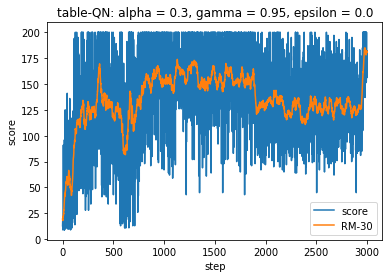

In [19]:
w = 15
plt.plot(last_reward)
plt.plot([last_reward[max(0, i-w):min(len(last_reward), i+w)].mean() for i in range(len(last_reward))])
plt.legend(['score', 'RM-{}'.format(2*w)])
plt.title('table-QN: alpha = {}, gamma = {}, epsilon = {}'.format(alpha, gamma, epsilon))
plt.xlabel('step')
plt.ylabel('score')
plt.show()

# Deep Q-learning


Если количество состояний велико, даже бесконечно ($~R^4$), то все запомнить не получится.

Приходится использовать апроксимацию Q-функции.

Например аппроксимацию нейронной сетью, т.е. $Q(s,a) = Q_{nn}(s,a|\theta)$, где $\theta$-веса сетки

<img src="https://pp.userapi.com/c840129/v840129239/4afe4/R9TwZiy1LoA.jpg" alt="MDP" style="width: 600px;"/>

Есть только история $(s, a, r, s')$, полученная при следовании данной политике.

Получим N таких значений и пересчитаем параметры $\theta$, т.е. веса нейронной сети:

$$Q_{target}(s,a) = r + gamma\cdot \max_{a'} Q(s',a' | \theta)$$
$$Loss(\theta) = \frac{1}{N} \sum_{(s,a,r,s') \in batch} \left[Q_target(s,a) - Q(s,a | \theta)\right]^2$$



In [20]:
import gym
import random
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

In [21]:
class DeepQ:
    def __init__(self, inputs, outputs, mem_size, gamma, learning_rate, epsilon, batch_size):
        """
        Параметры:
            - inputs: размерность входного вектора
            - outputs: размерность выходного вектора (к-во действий)
            - mem_size: размер буфера памяти
            - gamma: параметр затухания награды
            - learning_rate: множитель перед градиентом в SGD
            - batch_size: размер подвыборки для тренировки
        """
        self.actions = range(outputs)
        self.epsilon = epsilon
        self.input_size = inputs
        self.output_size = outputs
        self.memory = []
        self.mem_size = mem_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.global_i = 0
        self.model = self.create_model()
        
    def create_model(self):
        model = Sequential()
        hiddenLayers = [30,30]
#         hiddenLayers = [30]
        activationType = 'relu'
        model.add(Dense(hiddenLayers[0], input_shape=(self.input_size,), init='lecun_uniform'))
        model.add(Activation(activationType))

        for index in range(1, len(hiddenLayers)):
            model.add(Dense(hiddenLayers[index], init='lecun_uniform'))
            model.add(Activation(activationType))

#       На выходе числа из R
        model.add(Dense(self.output_size, init='lecun_uniform'))
        model.add(Activation("linear"))
        
#       Оптимизатор, чтобы устремлять Q -> Q_target
        optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-06)
    
#       Ф-я потерь sum((Q[:]-Q_target[:])**2)
        model.compile(loss="mse", optimizer=optimizer)
        model.summary()
        return model

    def get_Q_values(self, state):
        predicted = self.model.predict(state.reshape(1,-1))
        return predicted[0]
    
    def chooseAction(self, state):
        q = self.get_Q_values(state).tolist()
        maxQ = max(q)
        
        # Отвечает за баланс исследование-использование (exploration vs expluatation)
        # С вероятностью epsilon случайное действие, 1-epsilon - argmax(Q)
        if random.random() < self.epsilon:
            return random.choice(self.actions)

        count = q.count(maxQ)
        
        # Если максимум Q достигается для двух и более действий - берем любое
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            action = random.choice(best)
        else:
            action = q.index(maxQ)
        return action
    
        # Пересчет значения Q(s,a) := r + gamma * max Q(s',a')
    def calc_target(self, Q_values, reward, is_done):
        if is_done:
            return reward
        else : 
            return reward + self.gamma * max(Q_values)
    
    def remember(self, sarsd):
        if len(self.memory) < self.mem_size:
            self.memory.append(sarsd)
        else:
            self.memory[self.global_i%self.mem_size] = sarsd
        self.global_i += 1
        
    def learn(self):
        #выберем случайную подвыборку длины self.batch_size
        batch_indexes = random.sample(range(len(self.memory)), self.batch_size)
        
        #контейнеры  X = вход; Y = ответ
        X_batch = np.zeros((self.batch_size, self.input_size))
        Y_batch = np.zeros((self.batch_size, self.output_size))
        j = 0

        for i in batch_indexes:
        # выбираем из памяти s_t, a_t, r_t, s_{t+1} и метку конца 
            state, action, reward, new_state, is_done = self.memory[i]

            # Q_target(s,a) := r + gamma * max Q(s',a')
            Q_values = self.get_Q_values(state)
            Q_values_new = self.get_Q_values(new_state)
            Q_target = self.calc_target(Q_values_new, reward, is_done)

            # Для всех a, кроме a_t не трогаем, для a_t меняем
            X_batch[j] = np.array([state.copy()])
            Y_sample = Q_values.copy()
            Y_sample[action] = Q_target
            Y_batch[j] = np.array([Y_sample])
            
            
            if is_done:
                X_batch[j] = np.array([new_state.copy()])
                Y_batch[j] = np.array([[reward]*self.output_size])
            j += 1
            
#       Оптимизатор устремляет Q -> Q_target
#       т.е. делает 1 шаг против направления градиента ф-и потерь L = sum((Q[:]-Q_target[:])**2) по параметрам сетки
        self.model.fit(X_batch, Y_batch, batch_size = self.batch_size, nb_epoch=1, verbose = 0)

In [22]:
# env = gym.make('MsPacman-v0')
env = gym.make('CartPole-v1')
goal_average_steps = 475
goal_number_of_steps = 500


mem_size = 1024
gamma = 0.99
learning_rate = 0.01
epsilon = 0.1

batch_size  = 256
learn_step = 256
last_reward = np.ndarray(0)
state = env.reset().ravel()
env = gym.wrappers.Monitor(env, '/tmp/cartpole-experiment-1', force=True)
# Инициализация глубокого Q-learning
dqlearn = DeepQ(state.shape[0], env.action_space.n, mem_size, gamma, learning_rate, epsilon, batch_size)

for i_episode in range(3000):
    state = env.reset().ravel()
    cum_reward = 0
    for t in range(goal_number_of_steps):
#         можно смотреть, как агент учится
#         if (i_episode % 100 == 0): 
#             env.render()

        # в соответствии с политикой выберем действие
        action = dqlearn.chooseAction(state)
        
        # получим новое наблюдение, награду, метку конца эпизода
        new_state, reward, is_done, info = env.step(action)
        new_state = new_state.ravel()
        cum_reward += reward
        if not(is_done):
            dqlearn.remember((state, action, reward, new_state, is_done))
            state = new_state
        else:
        # штраф за поражение
            reward = -200
            dqlearn.remember((state, action, reward, new_state, is_done))
            last_reward = np.append(last_reward, cum_reward)
            break
            
    if dqlearn.global_i > learn_step:
#         print(dqlearn.global_i)
        dqlearn.learn()
    print("episode: {}, score: {}, 30-mean: {:0.1f}".format(i_episode, t, last_reward[-30:].mean()))
    if (last_reward[-100:].mean() > goal_average_steps):
        print ("Win!")
        break

env.close()
# gym.upload('/tmp/cartpole-experiment-1', algorithm_id='vmayoral simple Q-learning', api_key='your-key')

[2017-10-06 15:43:33,851] Making new env: CartPole-v1
[2017-10-06 15:43:33,860] Clearing 26 monitor files from previous run (because force=True was provided)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="lecun_uniform", input_shape=(4,))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="lecun_uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="lecun_uniform")`
[2017-10-06 15:43:33,916] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000000.mp4


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                150       
_________________________________________________________________
activation_3 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
activation_4 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 62        
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
_________________________________________________________________


[2017-10-06 15:43:34,222] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000001.mp4


episode: 0, score: 11, 30-mean: 12.0


[2017-10-06 15:43:34,458] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000008.mp4


episode: 1, score: 8, 30-mean: 10.5
episode: 2, score: 9, 30-mean: 10.3
episode: 3, score: 9, 30-mean: 10.2
episode: 4, score: 8, 30-mean: 10.0
episode: 5, score: 9, 30-mean: 10.0
episode: 6, score: 7, 30-mean: 9.7
episode: 7, score: 8, 30-mean: 9.6
episode: 8, score: 8, 30-mean: 9.6
episode: 9, score: 9, 30-mean: 9.6
episode: 10, score: 8, 30-mean: 9.5
episode: 11, score: 8, 30-mean: 9.5
episode: 12, score: 9, 30-mean: 9.5
episode: 13, score: 8, 30-mean: 9.5
episode: 14, score: 10, 30-mean: 9.6
episode: 15, score: 8, 30-mean: 9.6
episode: 16, score: 9, 30-mean: 9.6
episode: 17, score: 11, 30-mean: 9.7
episode: 18, score: 11, 30-mean: 9.8
episode: 19, score: 8, 30-mean: 9.8
episode: 20, score: 8, 30-mean: 9.8
episode: 21, score: 7, 30-mean: 9.7
episode: 22, score: 8, 30-mean: 9.7
episode: 23, score: 8, 30-mean: 9.6
episode: 24, score: 9, 30-mean: 9.6
episode: 25, score: 8, 30-mean: 9.6


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
[2017-10-06 15:43:35,071] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000027.mp4


episode: 26, score: 9, 30-mean: 9.6


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 27, score: 9, 30-mean: 9.6
episode: 28, score: 9, 30-mean: 9.7
episode: 29, score: 11, 30-mean: 9.7
episode: 30, score: 11, 30-mean: 9.7
episode: 31, score: 9, 30-mean: 9.8
episode: 32, score: 9, 30-mean: 9.8
episode: 33, score: 9, 30-mean: 9.8
episode: 34, score: 9, 30-mean: 9.8
episode: 35, score: 9, 30-mean: 9.8
episode: 36, score: 8, 30-mean: 9.8
episode: 37, score: 8, 30-mean: 9.8
episode: 38, score: 10, 30-mean: 9.9
episode: 39, score: 7, 30-mean: 9.8
episode: 40, score: 8, 30-mean: 9.8
episode: 41, score: 8, 30-mean: 9.8
episode: 42, score: 12, 30-mean: 9.9
episode: 43, score: 7, 30-mean: 9.9
episode: 44, score: 7, 30-mean: 9.8
episode: 45, score: 8, 30-mean: 9.8
episode: 46, score: 9, 30-mean: 9.8
episode: 47, score: 8, 30-mean: 9.7
episode: 48, score: 8, 30-mean: 9.6
episode: 49, score: 8, 30-mean: 9.6
episode: 50, score: 10, 30-mean: 9.7
episode: 51, score: 8, 30-mean: 9.7
episode: 52, score: 7, 30-mean: 9.7
episode: 53, score: 7, 30-mean: 9.6
episode: 54, score: 8, 

[2017-10-06 15:43:44,626] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000064.mp4


episode: 63, score: 9, 30-mean: 9.4


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 64, score: 7, 30-mean: 9.4
episode: 65, score: 9, 30-mean: 9.4
episode: 66, score: 7, 30-mean: 9.3
episode: 67, score: 11, 30-mean: 9.4
episode: 68, score: 9, 30-mean: 9.4
episode: 69, score: 7, 30-mean: 9.4
episode: 70, score: 9, 30-mean: 9.4
episode: 71, score: 8, 30-mean: 9.4
episode: 72, score: 28, 30-mean: 10.0
episode: 73, score: 37, 30-mean: 11.0
episode: 74, score: 26, 30-mean: 11.6
episode: 75, score: 27, 30-mean: 12.2
episode: 76, score: 42, 30-mean: 13.3
episode: 77, score: 52, 30-mean: 14.8
episode: 78, score: 46, 30-mean: 16.1
episode: 79, score: 76, 30-mean: 18.3
episode: 80, score: 62, 30-mean: 20.1
episode: 81, score: 45, 30-mean: 21.3
episode: 82, score: 55, 30-mean: 22.9
episode: 83, score: 168, 30-mean: 28.3
episode: 84, score: 47, 30-mean: 29.6
episode: 85, score: 101, 30-mean: 32.7
episode: 86, score: 57, 30-mean: 34.3
episode: 87, score: 55, 30-mean: 35.9
episode: 88, score: 95, 30-mean: 38.7
episode: 89, score: 51, 30-mean: 40.1
episode: 90, score: 40, 3

[2017-10-06 15:44:02,033] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000125.mp4


episode: 124, score: 40, 30-mean: 65.7


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 125, score: 27, 30-mean: 64.1
episode: 126, score: 31, 30-mean: 61.2
episode: 127, score: 29, 30-mean: 60.3
episode: 128, score: 47, 30-mean: 59.6
episode: 129, score: 41, 30-mean: 59.3
episode: 130, score: 67, 30-mean: 59.5
episode: 131, score: 56, 30-mean: 57.6
episode: 132, score: 49, 30-mean: 57.7
episode: 133, score: 142, 30-mean: 60.7
episode: 134, score: 90, 30-mean: 61.6
episode: 135, score: 37, 30-mean: 60.7
episode: 136, score: 55, 30-mean: 61.0
episode: 137, score: 16, 30-mean: 59.0
episode: 138, score: 450, 30-mean: 70.6
episode: 139, score: 39, 30-mean: 70.7
episode: 140, score: 56, 30-mean: 70.8
episode: 141, score: 39, 30-mean: 64.5
episode: 142, score: 92, 30-mean: 65.1
episode: 143, score: 34, 30-mean: 62.5
episode: 144, score: 109, 30-mean: 65.0
episode: 145, score: 46, 30-mean: 64.3
episode: 146, score: 167, 30-mean: 68.6
episode: 147, score: 44, 30-mean: 69.0
episode: 148, score: 33, 30-mean: 69.2
episode: 149, score: 41, 30-mean: 68.9
episode: 150, score: 

[2017-10-06 15:44:29,558] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000216.mp4


episode: 215, score: 194, 30-mean: 101.5


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 216, score: 58, 30-mean: 101.5
episode: 217, score: 69, 30-mean: 102.0
episode: 218, score: 45, 30-mean: 100.4
episode: 219, score: 162, 30-mean: 102.7
episode: 220, score: 50, 30-mean: 101.2
episode: 221, score: 100, 30-mean: 102.9
episode: 222, score: 141, 30-mean: 104.4
episode: 223, score: 150, 30-mean: 107.8
episode: 224, score: 85, 30-mean: 107.9
episode: 225, score: 147, 30-mean: 111.4
episode: 226, score: 109, 30-mean: 106.1
episode: 227, score: 175, 30-mean: 110.4
episode: 228, score: 126, 30-mean: 112.3
episode: 229, score: 217, 30-mean: 117.1
episode: 230, score: 152, 30-mean: 120.4
episode: 231, score: 74, 30-mean: 120.1
episode: 232, score: 99, 30-mean: 117.0
episode: 233, score: 113, 30-mean: 118.9
episode: 234, score: 230, 30-mean: 124.0
episode: 235, score: 132, 30-mean: 122.4
episode: 236, score: 184, 30-mean: 119.1
episode: 237, score: 323, 30-mean: 128.9
episode: 238, score: 184, 30-mean: 131.0
episode: 239, score: 86, 30-mean: 130.9
episode: 240, score: 125

[2017-10-06 15:45:07,992] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000343.mp4


episode: 342, score: 67, 30-mean: 62.6


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 343, score: 331, 30-mean: 72.1
episode: 344, score: 335, 30-mean: 80.8
episode: 345, score: 75, 30-mean: 82.0
episode: 346, score: 48, 30-mean: 81.7
episode: 347, score: 236, 30-mean: 87.3
episode: 348, score: 140, 30-mean: 89.8
episode: 349, score: 138, 30-mean: 92.2
episode: 350, score: 146, 30-mean: 95.6
episode: 351, score: 79, 30-mean: 97.1
episode: 352, score: 100, 30-mean: 98.1
episode: 353, score: 87, 30-mean: 99.6
episode: 354, score: 178, 30-mean: 101.5
episode: 355, score: 69, 30-mean: 102.0
episode: 356, score: 91, 30-mean: 102.7
episode: 357, score: 165, 30-mean: 106.1
episode: 358, score: 80, 30-mean: 107.0
episode: 359, score: 74, 30-mean: 106.6
episode: 360, score: 92, 30-mean: 108.1
episode: 361, score: 100, 30-mean: 110.1
episode: 362, score: 309, 30-mean: 118.6
episode: 363, score: 90, 30-mean: 119.6
episode: 364, score: 202, 30-mean: 124.7
episode: 365, score: 49, 30-mean: 125.1
episode: 366, score: 156, 30-mean: 128.3
episode: 367, score: 170, 30-mean: 131

[2017-10-06 15:46:23,011] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.4.10617.video000512.mp4


episode: 511, score: 499, 30-mean: 492.6


/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


episode: 512, score: 499, 30-mean: 492.6
episode: 513, score: 499, 30-mean: 492.6
episode: 514, score: 201, 30-mean: 482.7
episode: 515, score: 499, 30-mean: 482.7
episode: 516, score: 499, 30-mean: 482.7
episode: 517, score: 499, 30-mean: 482.7
episode: 518, score: 499, 30-mean: 482.7
episode: 519, score: 499, 30-mean: 482.7
episode: 520, score: 499, 30-mean: 482.7
episode: 521, score: 499, 30-mean: 482.7
episode: 522, score: 499, 30-mean: 482.7
episode: 523, score: 499, 30-mean: 482.7
episode: 524, score: 76, 30-mean: 468.6
episode: 525, score: 499, 30-mean: 468.6
episode: 526, score: 499, 30-mean: 468.6
episode: 527, score: 499, 30-mean: 472.0
episode: 528, score: 182, 30-mean: 461.5
episode: 529, score: 499, 30-mean: 461.5
episode: 530, score: 499, 30-mean: 461.5
episode: 531, score: 499, 30-mean: 461.5
episode: 532, score: 499, 30-mean: 461.5
episode: 533, score: 499, 30-mean: 461.5
episode: 534, score: 499, 30-mean: 461.5
episode: 535, score: 499, 30-mean: 461.5
episode: 536, sco

[2017-10-06 15:46:47,693] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment-1')


episode: 544, score: 499, 30-mean: 473.2
Win!


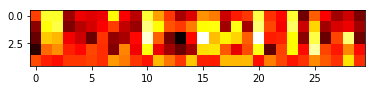

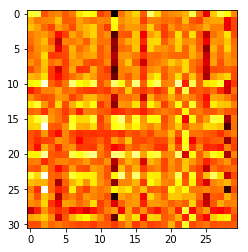

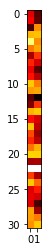

In [23]:
from keras.utils import plot_model
learned_model = dqlearn.model
# plot_model(learned_model)


for layer in learned_model.layers:
    weights = layer.get_weights() # list of numpy arrays
    if len(weights) > 1:
        out = np.vstack(weights)
        plt.imshow(out, cmap='hot', interpolation='nearest')
        plt.show()


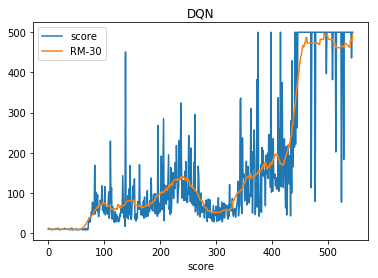

In [24]:
w = 15
plt.plot(last_reward)
plt.plot([last_reward[max(0, i-w):min(len(last_reward), i+w)].mean() for i in range(len(last_reward))])
plt.legend(['score', 'RM-{}'.format(2*w)])
plt.title('DQN')
plt.xlabel('step')
plt.xlabel('score')
plt.show()

## Домашнее задание

0. Проследить зависимость результата от epsilon, построить графики для epsilon = [0.01, 0.07, 0.2, 0.5];
0. Проследить зависимость результата от learning_rate, построить графики для разных learning_rate;
0. Динамически менять epsilon и learning_rate, обучиться быстрее и стабильнее
0. Усложнить модель, добавить слои, поменять число нейронов, ф-ию активации;
0. $^*$ Решить [MountainCar-v0](https://gym.openai.com/envs/MountainCar-v0/) в OpenAI.gym.